<a href="https://colab.research.google.com/github/ferit-osirv/lab8/blob/main/lab8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 8 -  Single and multi-label classification with ResNets

Ove laboratorijske vježbe se rješavaju u Google Colabu i spremaju na GitHub repozitorij koji je povezan na GitHub Classroom.

## Kako riješiti zadatke?

1. Prihvatite zadatak putem Google Classroom linka koji ćete dobiti. Google Classroom će kreirati repozitorij na vašem računu.
2. Uđite u novokreiran repozitorij na vašem računu i kliknite na **.ipynb** datoteku, zatim kliknite **Open in Colab**.
3. Zadatke rješavate u Google Colabu.

## Kako spremiti (predati) zadatke?

1. Unutar **Google Colaba** kliknite na **Open settings** kotačić u gornjem desnom kutu.
2. Kliknite na **GitHub** tab i odaberite kvačicu za **Access private repositories and organizations**.
3. Otvorit će se novi prozor da dodate pristup GitHubu. Kod **ferit-osirv** kliknite **Grant**.  
4. Spremite i izađite iz postavki.


5. Kliknite na **File > Save a copy in GitHub**.
6. Odaberite kreiran repozitorij labosa **koji uključuje vaše ime**.

> *Napomena:* Korake 1-4 morate napraviti samo prvi put.

# Introduction

In this lab, we will build on top of the CNNs introduced in the previous (lab7) and explain to you the ResNet (residual network) architecture. Although CNNs perform well, the limited amount of annotated data requires the development of efficient and more complex, deeper network architectures. Deep convolutional neural networks have shown a significant increase in the accuracy for various segmentation and classification tasks.

ResNet was introduced in 2015 by Kaiming He et al. in the article ["Deep Residual Learning for Image Recognition"](https://arxiv.org/abs/1512.03385) and is by far the most used model architecture nowadays. More recent developments in image models almost always use the same trick of residual connections, and most of the time, they are just a tweak of the original ResNet.

We will first show you the basic ResNet as it was first designed, then explain to you what modern tweaks make it more performant.






### Deep Residual Networks (ResNets)

After the first CNN-based architecture (AlexNet) that win the ImageNet 2012 competition, every subsequent winning architecture uses more layers in a deep neural network to reduce the error rate. This works for less number of layers, but when we increase the number of layers, there is a common problem in deep learning associated with that called Vanishing/Exploding gradient. This causes the gradient to become 0 or too large. Thus when we increases number of layers, the training and test error rate also increases.

<p align="center">
  <img src="https://i.ibb.co/0n06TVs/resnet.png">
</p>




In the above plot, we can observe that a 56-layer CNN gives more error rate on both training and testing dataset than a 20-layer CNN architecture, If this was the result of over fitting, then we should have lower training error in 56-layer CNN but then it also has higher training error. After analyzing more on error rate the authors were able to reach conclusion that it is caused by vanishing/exploding gradient (as the depth of CNN increases, information about the gradient passes through many layers, and it can vanish or accumulate large errors by the time it reaches the end of the network).



### Residual Block

In order to solve the problem of the vanishing/exploding gradient, this architecture introduced the concept called Residual Network. In this network we use a technique called skip connections . The skip connection skips training from a few layers and connects directly to the output.

The approach behind this network is instead of layers learn the underlying mapping, we allow network fit the residual mapping. So, instead of say H(x), initial mapping, let the network fit, F(x)= H(x)–x which gives H(x)=F(x)+x.

<p align="center">
  <img src="https://i.ibb.co/cTkwsZt/residual-block.png">
</p>

The advantage of adding this type of skip connection is because if any layer hurt the performance of architecture then it will be skipped by regularization. So, this results in training very deep neural network without the problems caused by vanishing/exploding gradient.



### ResNet Network Architecture

The first ResNet architecture was the Resnet-34, which involved the insertion of shortcut connections in turning a plain network into its residual network counterpart. In this case, the plain network was inspired by VGG neural networks (VGG-16, VGG-19), with the convolutional networks having 3×3 filters. However, compared to VGGNets, ResNets have fewer filters and lower complexity. The 34-layer ResNet achieves a performance of 3.6 bn FLOPs, compared to 1.8bn FLOPs of smaller 18-layer ResNets.

It also followed two simple design rules –  the layers had the same number of filters for the same output feature map size, and the number of filters doubled in case the feature map size was halved in order to preserve the time complexity per layer. It consisted of 34 weighted layers.

The shortcut connections were added to this plain network. While the input and output dimensions were the same, the identity shortcuts were directly used. With an increase in the dimensions, there were two options to be considered. The first was that the shortcut would still perform identity mapping while extra zero entries would be padded for increasing dimensions. The other option was to use the projection shortcut to match dimensions. Comparison of plain network i ResNet is shown below:

<p align="center">
  <img src="https://i.ibb.co/kGFPw9M/resnet-vs-plain.png">
</p>

Various improvements of an original ResNet34 are developed through the years. One example is Resnet50 architecture which introduced one major difference. In the case of ResNet50, the building block was modified into a bottleneck design due to concerns over the time taken to train the layers. This used a stack of 3 layers instead of the earlier 2.

Therefore, each of the 2-layer blocks in Resnet34 was replaced with a 3-layer bottleneck block, forming the Resnet 50 architecture. This has much higher accuracy than the 34-layer ResNet model. The 50-layer ResNet achieves a performance of 3.8bn FLOPS!



Now we will implement ResNet34 and ResNet50 for the task of single and multiple label classification.

Training will take a lot of time, you may go and grab some coffee while waiting...

# Single lable classification

For this task, we will use the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) that contains images of cats and dogs of 37 different breeds. We will first show how to build a simple cat-vs-dog classifier.

In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)

It will only do this download once, and return the location of the decompressed archive. We can check what is inside with the `.ls()` method.

In [ ]:
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/images'),Path('/root/.fastai/data/oxford-iiit-pet/annotations')]

We will ignore the annotations folder for now, and focus on the images one. `get_image_files` is a fastai function that helps us grab all the image files (recursively) in one folder.

In [ ]:
files = get_image_files(path/"images")
len(files)

7390

To label our data for the cats vs dogs problem, we need to know which filenames are of dog pictures and which ones are of cat pictures. There is an easy way to distinguish: the name of the file begins with a capital for cats, and a lowercased letter for dogs.

In [ ]:
files[0],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/great_pyrenees_175.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_165.jpg'))

We can then define an easy label function:

In [ ]:
def label_func(f): return f[0].isupper()

To get our data ready for a model, we need to put it in a `DataLoaders` object. Here we have a function that labels using the file names, so we will use `ImageDataLoaders.from_name_func`. There are other factory methods of `ImageDataLoaders` that could be more suitable for your problem, so make sure to check them all in `vision.data`.

In [ ]:
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

We have passed to this function the directory we're working in, the `files` we grabbed, our `label_func` and one last piece as `item_tfms`: this is a `Transform` applied on all items of our dataset that will resize each image to 224 by 224, by using a random crop on the largest dimension to make it a square, then resizing to 224 by 224. If we didn't pass this, we would get an error later as it would be impossible to batch the items together.

We can then check if everything looks okay with the `show_batch` method (`True` is for cat, `False` is for dog):

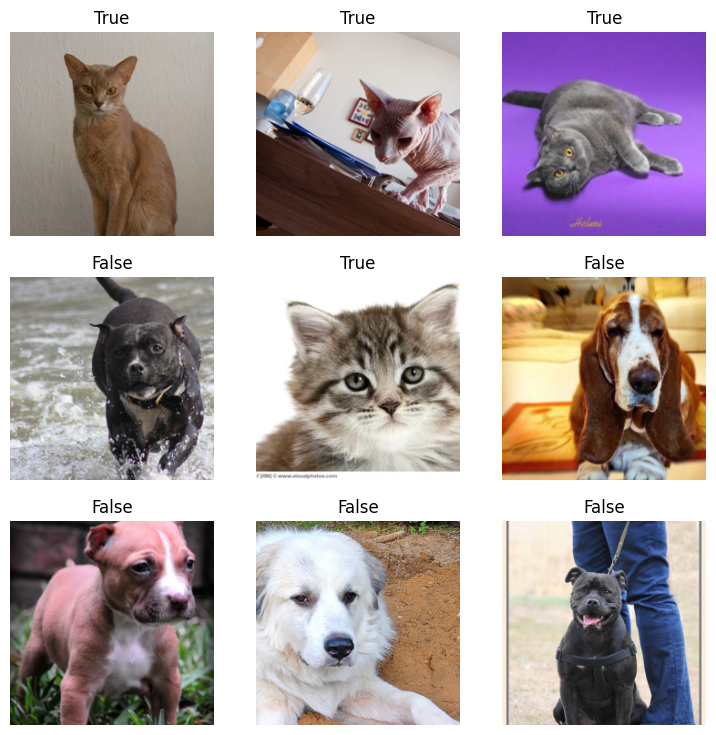

In [ ]:
dls.show_batch()

Then we can create a `Learner`, which is a fastai object that combines the data and a model for training, and uses transfer learning to fine tune a pretrained model in just two lines of code:

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 127MB/s]


The first line downloaded a model called ResNet34, pretrained on [ImageNet](http://www.image-net.org/), and adapted it to our specific problem. It then fine tuned that model and in a relatively short time, we get a model with an error rate of 0.3%... amazing!

If you want to make a prediction on a new image, you can use `learn.predict`:

In [ ]:
learn.predict(files[0])

('False', tensor(0), tensor([1.0000e+00, 5.9711e-07]))

The predict method returns three things: the decoded prediction (here `False` for dog), the index of the predicted class and the tensor of probabilities of all classes in the order of their indexed labels(in this case, the model is quite confifent about the being that of a dog). This method accepts a filename, a PIL image or a tensor directly in this case.
We can also have a look at some predictions with the `show_results` method:

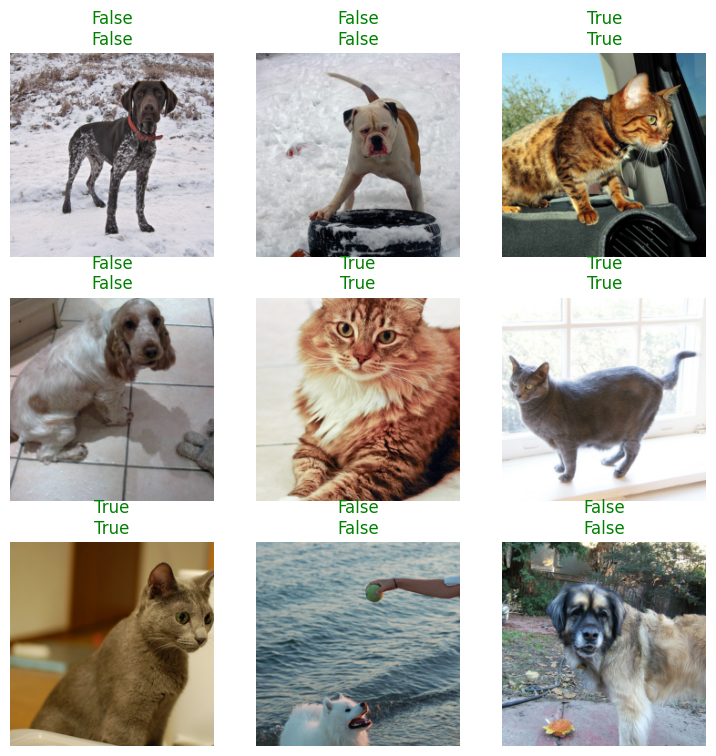

In [ ]:
learn.show_results()

# Multi-label classification

For this task, we will use the [Pascal Dataset](http://host.robots.ox.ac.uk/pascal/VOC/) that contains images with different kinds of objects/persons. It's orginally a dataset for object detection, meaning the task is not only to detect if there is an instance of one class of an image, but to also draw a bounding box around it. Here we will just try to predict all the classes in one given image.

Multi-label classification defers from before in the sense each image does not belong to one category. An image could have a person *and* a horse inside it for instance. Or have none of the categories we study.

As before, we can download the dataset pretty easily:

In [ ]:
path = untar_data(URLs.PASCAL_2007)
path.ls()

(#8) [Path('/root/.fastai/data/pascal_2007/valid.json'),Path('/root/.fastai/data/pascal_2007/train.csv'),Path('/root/.fastai/data/pascal_2007/test'),Path('/root/.fastai/data/pascal_2007/test.csv'),Path('/root/.fastai/data/pascal_2007/test.json'),Path('/root/.fastai/data/pascal_2007/segmentation'),Path('/root/.fastai/data/pascal_2007/train'),Path('/root/.fastai/data/pascal_2007/train.json')]

The information about the labels of each image is in the file named `train.csv`. We load it using pandas:

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

fname        labels  is_valid
0  000005.jpg         chair      True
1  000007.jpg           car      True
2  000009.jpg  horse person      True
3  000012.jpg           car     False
4  000016.jpg       bicycle      True

So, what exactly multi-label classification means? That's pretty straightforward: for each filename, we will get the different labels (separated by space) and the last column tells if it's in the validation set or not. To get this in `DataLoaders` quickly, we have a factory method, `from_df`. We can specify the underlying path where all the images are, an additional folder to add between the base path and the filenames (here `train`), the `valid_col` to consider for the validation set (if we don't specify this, we take a random subset), a `label_delim` to split the labels and, as before, `item_tfms` and `batch_tfms`.

Note that we don't have to specify the `fn_col` and the `label_col` because they default to the first and second column respectively.

In [ ]:
dls = ImageDataLoaders.from_df(df, path, folder='train', valid_col='is_valid', label_delim=' ',
                               item_tfms=Resize(460), batch_tfms=aug_transforms(size=224))

As before, we can then have a look at the data with the `show_batch` method.

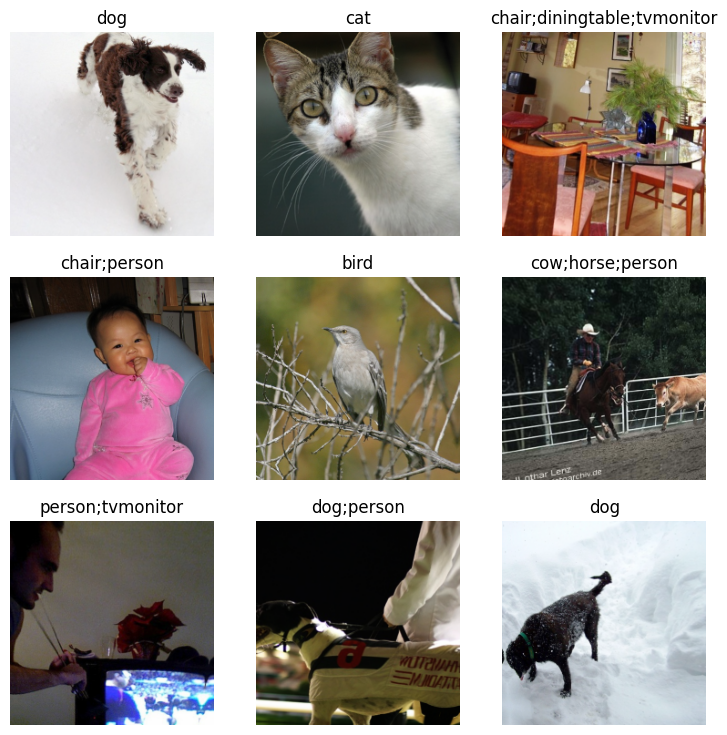

In [ ]:
dls.show_batch()

Training a model is as easy (but takes a lot of time, depending on GPU) as before: the same functions can be applied and the fastai library will automatically detect that we are in a multi-label problem, thus picking the right loss function. The only difference is in the metric we pass: `error_rate` will not work for a multi-label problem, but we can use `accuracy_thresh`.

In [ ]:
learn = cnn_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.5))

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


As before, we can use `learn.lr_find` to pick a good learning rate:

SuggestedLRs(valley=0.0020892962347716093)

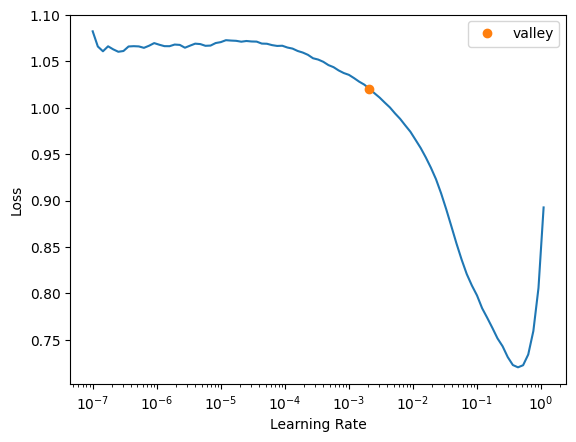

In [ ]:
learn.lr_find()

We can pick the suggested learning rate and fine-tune our pretrained model:

In [ ]:
learn.fine_tune(2, 3e-2)

Like before, we can easily have a look at the results:

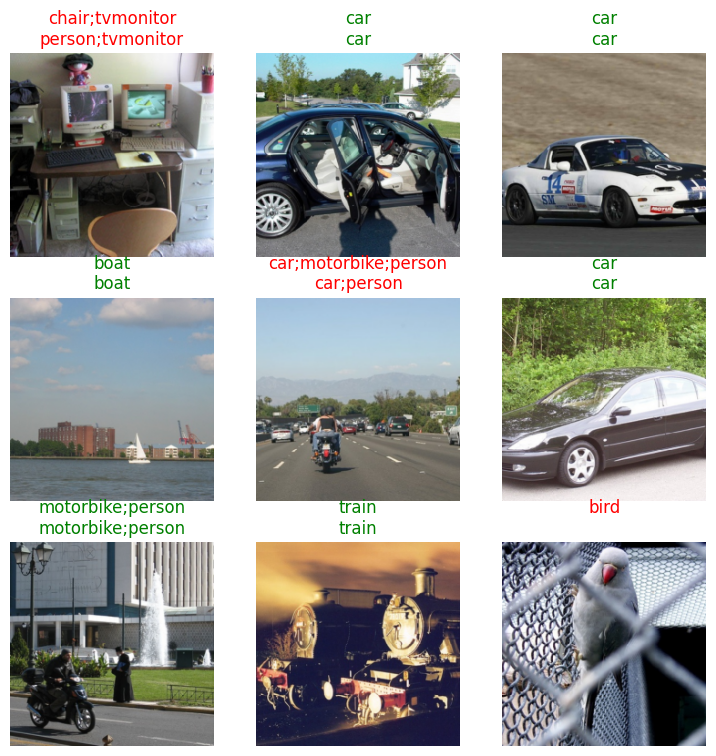

In [ ]:
learn.show_results()

Or get the predictions on a given image:

In [ ]:
learn.predict(path/'train/000005.jpg')

((#3) ['chair','diningtable','sofa'],
 tensor([False, False, False, False, False, False, False, False,  True, False,
          True, False, False, False, False, False, False,  True, False, False]),
 tensor([8.0710e-04, 1.3744e-03, 1.8951e-04, 8.2503e-04, 4.6769e-02, 1.6899e-03,
         2.9273e-03, 5.7522e-03, 9.7708e-01, 3.5784e-04, 6.4832e-01, 6.3356e-03,
         1.0005e-03, 3.6236e-04, 3.8003e-01, 2.8574e-01, 2.5020e-04, 7.1369e-01,
         1.4378e-03, 1.0278e-01]))

As for the single classification predictions, we get three things. The last one is the prediction of the model on each class (going from 0 to 1). The second to last cooresponds to a one-hot encoded targets (you get `True` for all predicted classes, the ones that get a probability > 0.5) and the first is the decoded, readable version.

And like before, we can check where the model did its worse:

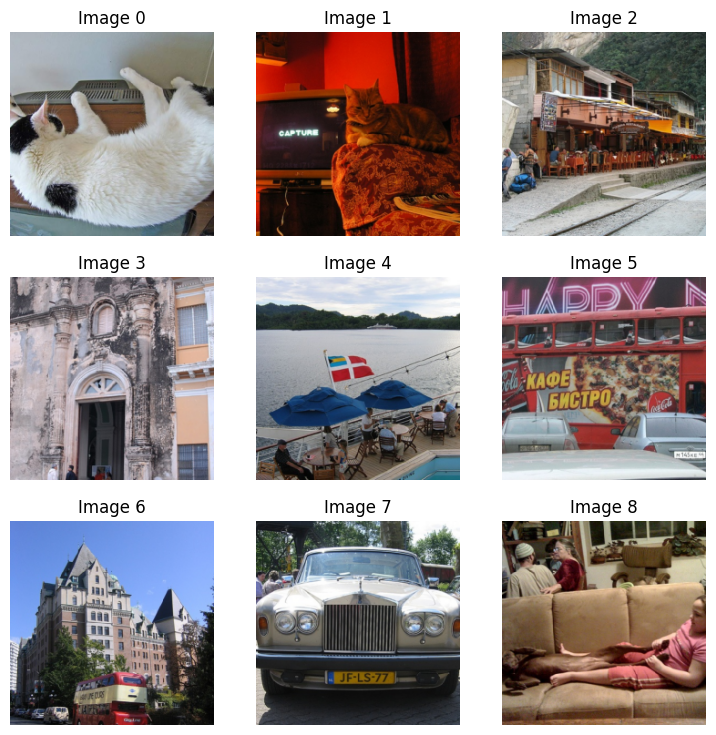

In [ ]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(9)